# Features as points

In this notebook we use HOG and LBT on the whole image.

There are several notebooks, because if we would put all the resutls together, it would be confusing to navigate and understand, which result relate to which method.

In [1]:
from enum import Enum
from pathlib import Path
from itertools import chain
from matplotlib import pyplot as plt

import numpy as np
import cv2

from skimage import feature
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier

np.random.seed(42)

TFEID_COLOR_PATH = Path('data/dfh_all/dfh_color/')

class Expression(Enum):
    ANGER = 1
    CONTEMPT = 2
    DISGUST = 3 
    FEAR = 4
    HAPPINESS = 5
    NEUTRAL = 6
    SADNESS = 7
    SURPRISE = 8

folder = {
    Expression.ANGER     : Path('dfh_anger_c'),
    Expression.CONTEMPT  : Path('dfh_contempt_c'),
    Expression.DISGUST   : Path('dfh_disguest_c'),
    Expression.FEAR      : Path('dfh_fear_c'),
    Expression.HAPPINESS : Path('dfh_happiness_c'),
    Expression.NEUTRAL   : Path('dfh_neutral_c'),
    Expression.SADNESS   : Path('dfh_sadness_c'),
    Expression.SURPRISE  : Path('dfh_surprise_c'),
}    
    
def read_images_expr(path:Path, expr:Expression):
    images = []
    labels = []
    expr_path = path.joinpath(folder[expr])
    for img_path in expr_path.iterdir():
        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(expr.value)
    return images, labels

def read_images(path):
    images, labels = [], []
    for expr in Expression:
        expr_images, expr_labels = read_images_expr(path, expr=expr)
        print(expr, len(expr_images), len(expr_labels))
        images+=expr_images
        labels+=expr_labels
    return images, labels

tfeid_images, tfeid_labels = read_images(TFEID_COLOR_PATH)

Expression.ANGER 34 34
Expression.CONTEMPT 68 68
Expression.DISGUST 40 40
Expression.FEAR 40 40
Expression.HAPPINESS 40 40
Expression.NEUTRAL 39 39
Expression.SADNESS 39 39
Expression.SURPRISE 36 36


In [2]:
def show_metrics(model, pred_y, test_x, test_y):
    print(f'Accuracy: {accuracy_score(test_y, pred_y)}')
    expr_names = [expr.name for expr in Expression]
    plot_confusion_matrix(model, test_x, test_y,
                          display_labels=np.array(expr_names),
                          xticks_rotation=45.0)
    plt.show() 
    print(classification_report(test_y,pred_y,
                                target_names=expr_names,
                                zero_division=0))

In [3]:
import dlib
from collections import OrderedDict
FACIAL_LANDMARKS_INDEXES = OrderedDict([
    ("Mouth", (48, 68)),
    ("Right_Eyebrow", (17, 22)),
    ("Left_Eyebrow", (22, 27)),
    ("Right_Eye", (36, 42)),
    ("Left_Eye", (42, 48)),
    ("Nose", (27, 35)),
    ("Jaw", (0, 17))
])

detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor("data/tools/shape_predictor_68_face_landmarks.dat")

img_pulp = cv2.imread('data/dfh_un-rimmed/dfh_anger_x/f01_dfh_ax.jpg')

def get_points(img_pulp):
    gray = cv2.cvtColor(src=img_pulp, code=cv2.COLOR_RGB2GRAY)
    face = detector(gray)[0]

    image = img_pulp[face.top():face.bottom(), face.left():face.right()]

    landmarks = predictor(image=gray, box=face)
    features = []
    for name, ind in FACIAL_LANDMARKS_INDEXES.items():
        feature = []
        for i in range(ind[0], ind[1]):
            feature.append([landmarks.part(i).x, landmarks.part(i).y])
        f_x, f_y = zip(*feature)
        y_min = np.min(f_y);y_max = np.max(f_y)
        x_min = np.min(f_x);x_max = np.max(f_x)
        
        normalize_x =lambda x : (x-x_min)/(x_max-x_min)
        normalize_y =lambda y : (y-y_min)/(y_max-y_min)

        feature = np.ravel([[normalize_x(x), normalize_y(y)] for x,y in feature])
        features = np.append(features,feature)
    return np.ravel(features)
get_points(img_pulp)

array([0.        , 0.56923077, 0.19333333, 0.21538462, 0.37333333,
       0.        , 0.51333333, 0.09230769, 0.64666667, 0.01538462,
       0.81333333, 0.23076923, 1.        , 0.58461538, 0.82      ,
       0.84615385, 0.65333333, 0.96923077, 0.51333333, 1.        ,
       0.36666667, 0.95384615, 0.19333333, 0.83076923, 0.08666667,
       0.53846154, 0.37333333, 0.43076923, 0.51333333, 0.47692308,
       0.64666667, 0.44615385, 0.92      , 0.56923077, 0.64666667,
       0.47692308, 0.51333333, 0.52307692, 0.37333333, 0.47692308,
       0.        , 1.        , 0.2       , 0.14814815, 0.47142857,
       0.        , 0.74285714, 0.33333333, 1.        , 0.81481481,
       0.        , 0.71875   , 0.25547445, 0.25      , 0.53284672,
       0.        , 0.81021898, 0.1875    , 1.        , 1.        ,
       0.        , 0.63157895, 0.32      , 0.        , 0.68      ,
       0.        , 1.        , 0.78947368, 0.65333333, 1.        ,
       0.30666667, 1.        , 0.        , 0.75      , 0.33333

In [4]:
np.random.seed(42)

# Preprocessing stage (extracting the face from input) was done together with feature extraction
# because it is more efficient and convinient
def preprocess_single(img):
    return img

def preprocess(images):
    return np.stack([preprocess_single(img) for img in images])

def extract_features(images, method):
    return np.array([method(img) for img in images])

# tfeid_x = preprocess(tfeid_images)
tfeid_x = extract_features(tfeid_images, method=get_points)
tfeid_labels = np.array(tfeid_labels)
train_x, test_x, train_y, test_y = train_test_split(tfeid_x, tfeid_labels, stratify=tfeid_labels)

In [5]:
np.random.seed(42)

# 'rbf', 'sigmoid'
param_grid = {
    'base_estimator':[DecisionTreeClassifier(max_depth=i) for i in range(5,8)],
    'learning_rate':np.logspace(-3, 1, 50),
}

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, verbose=True, n_jobs=4)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   56.1s
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed:  1.5min finished
{'base_estimator': DecisionTreeClassifier(max_depth=6), 'learning_rate': 1.0481131341546852}
0.8490980392156864


Accuracy: 0.8095238095238095


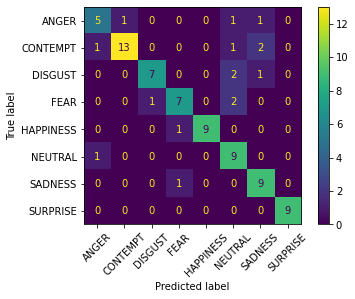

              precision    recall  f1-score   support

       ANGER       0.71      0.62      0.67         8
    CONTEMPT       0.93      0.76      0.84        17
     DISGUST       0.88      0.70      0.78        10
        FEAR       0.78      0.70      0.74        10
   HAPPINESS       1.00      0.90      0.95        10
     NEUTRAL       0.60      0.90      0.72        10
     SADNESS       0.69      0.90      0.78        10
    SURPRISE       1.00      1.00      1.00         9

    accuracy                           0.81        84
   macro avg       0.82      0.81      0.81        84
weighted avg       0.83      0.81      0.81        84



In [6]:
np.random.seed(42)

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),learning_rate=1.2648552168552958)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)

In [7]:
param_grid = {
    'degree':range(3,10),
    'C':np.logspace(-3, 2, 50, base = 10),
    'kernel':['poly']
}

grid_search = GridSearchCV(SVC(), param_grid=param_grid, verbose=True, n_jobs=4)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    0.9s
{'C': 0.04291934260128778, 'degree': 8, 'kernel': 'poly'}
0.8013333333333332
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    4.0s finished
